# Explore here

In [65]:
# Your code here
import numpy as np, random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import os.path
import joblib
#https://4geeks.com/es/syllabus/spain-ds-pt-10/project/proyecto-de-regresion-lineal-regularizada

EDA:
PASO1) OBTENCION Y LIMPIEZA DE DATOS.

In [66]:
df_rd= pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv')
df_rd.to_csv("../data/raw/df_rd.csv", index=False)
df_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [67]:
df_rd = df_rd.drop_duplicates().reset_index(drop = True)
df_rd = df_rd.fillna(0)
df_rd.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


Mi variable target va a ser el numero TOTAL DE INDIVIDUOS CON DIABETES, quiero observar como influyen predictoras de caracter sociologico, como por ejemplo si  influye la localizacion del individuo y el tipo de actividad economica que predomina esa area,
por ejemplo localizaciones de interior, pueblos rurales con poca poblacion, si hay mucha correlacion de diabetes y posible fallo cardiaco. Suponiendo que trabajos sedentarios son minimos en este tipo de localidades.

In [68]:
#1) Numero y tipo de variables:
def vartype(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    df_tipos = pd.DataFrame({'Tipo': ['Numérica']*len(num_cols) + ['Categórica']*len(cat_cols),
                            'Columna': num_cols + cat_cols})
    total_num = len(num_cols)
    total_cat = len(cat_cols)
    total_general = total_num + total_cat
    # Crear una lista de diccionarios para las nuevas filas
    new_rows = [{'Tipo': 'Total Numérico', 'Columna': total_num},
                {'Tipo': 'Total Categórico', 'Columna': total_cat},
                {'Tipo': 'Total General', 'Columna': total_general},]
    df_tipos = pd.concat([df_tipos, pd.DataFrame(new_rows)], ignore_index=True)
    return df_tipos
df_rd_vars= vartype(df_rd)
print(df_rd_vars)

                 Tipo                 Columna
0            Numérica                    fips
1            Numérica                 TOT_POP
2            Numérica                     0-9
3            Numérica  0-9 y/o % of total pop
4            Numérica                  19-Oct
..                ...                     ...
106        Categórica             COUNTY_NAME
107        Categórica              STATE_NAME
108    Total Numérico                     106
109  Total Categórico                       2
110     Total General                     108

[111 rows x 2 columns]


['COUNTY_NAME' 'STATE_NAME']


/tmp/ipykernel_4037/1674371727.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_4037/1674371727.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


[Text(0, 0, 'Texas'),
 Text(1, 0, 'Georgia'),
 Text(2, 0, 'Virginia'),
 Text(3, 0, 'Kentucky'),
 Text(4, 0, 'Missouri'),
 Text(5, 0, 'Kansas'),
 Text(6, 0, 'Illinois'),
 Text(7, 0, 'North Carolina'),
 Text(8, 0, 'Iowa'),
 Text(9, 0, 'Tennessee'),
 Text(10, 0, 'Nebraska'),
 Text(11, 0, 'Indiana'),
 Text(12, 0, 'Ohio'),
 Text(13, 0, 'Minnesota'),
 Text(14, 0, 'Michigan'),
 Text(15, 0, 'Mississippi'),
 Text(16, 0, 'Oklahoma'),
 Text(17, 0, 'Arkansas'),
 Text(18, 0, 'Wisconsin'),
 Text(19, 0, 'Pennsylvania'),
 Text(20, 0, 'Alabama'),
 Text(21, 0, 'Florida'),
 Text(22, 0, 'South Dakota'),
 Text(23, 0, 'Louisiana'),
 Text(24, 0, 'Colorado'),
 Text(25, 0, 'New York'),
 Text(26, 0, 'California'),
 Text(27, 0, 'Montana'),
 Text(28, 0, 'West Virginia'),
 Text(29, 0, 'North Dakota'),
 Text(30, 0, 'South Carolina'),
 Text(31, 0, 'Idaho'),
 Text(32, 0, 'Washington'),
 Text(33, 0, 'Oregon'),
 Text(34, 0, 'New Mexico'),
 Text(35, 0, 'Utah'),
 Text(36, 0, 'Alaska'),
 Text(37, 0, 'Maryland'),
 Text(38,

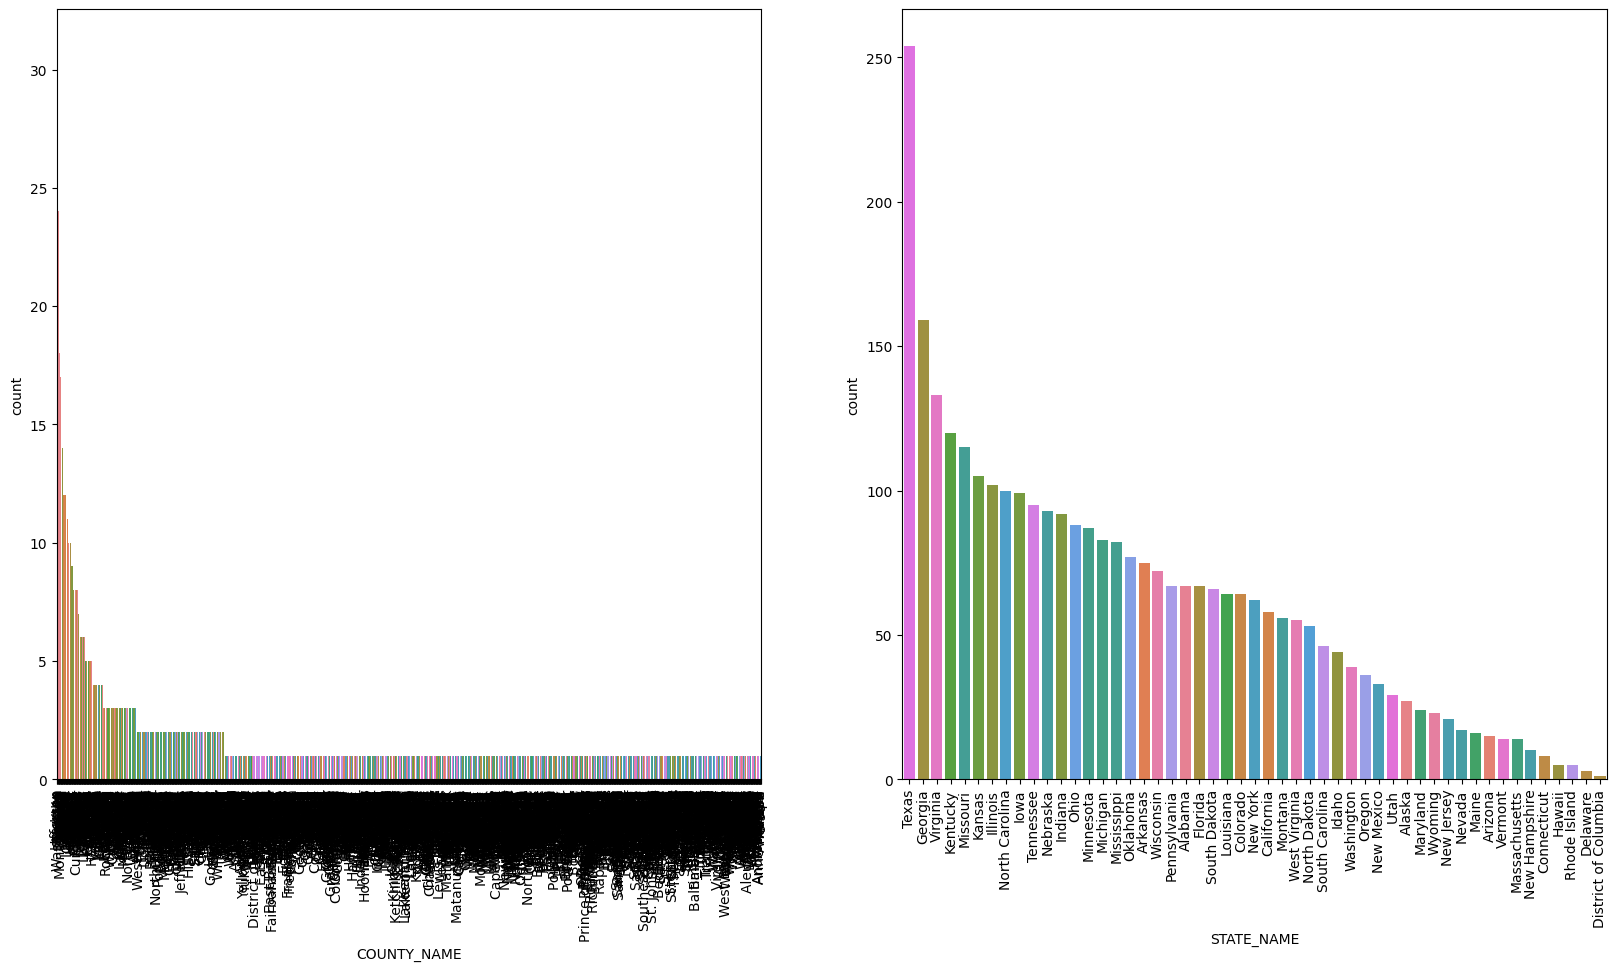

In [69]:
#2)Análisis categóricas.
print(df_rd_vars[df_rd_vars['Tipo'] == 'Categórica']['Columna'].unique())
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(ax=axs[0],  # Access the first axis directly
               data=df_rd,
               x='COUNTY_NAME',
               hue='COUNTY_NAME',
               order=df_rd['COUNTY_NAME'].sort_values().value_counts().index)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.countplot(ax=axs[1],  # Access the second axis directly
               data=df_rd,
               x='STATE_NAME',
               hue='STATE_NAME',
               order=df_rd['STATE_NAME'].sort_values().value_counts().index)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

Como conclusion de este analisis de las variables categoricas podemos observar que las dos graficas tienen una distribucion parecida, en el caso de COUNTY_NAME es mas despreciable su distribucion normal, no es el caso de STATE_NAME.
Estas variables hacen referencia a las ciudades y condados de estados unidos de donde provienen los datos médicos


In [70]:
#3.1)Factorización de variables categoricas.
from sklearn.preprocessing import LabelEncoder
import json
import os

def JsonFCZRename(df, categorical_cols, output_dir, suffix="_fc"):
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        class_labels_str = [str(label) for label in le.classes_]
        mapping_dict = {str(value): str(index) for value, index in zip(class_labels_str, le.transform(class_labels_str))}
        print(f"Column: {col}")
        print(mapping_dict)
        filename = f"{col}_factors.json"
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(mapping_dict, f, indent=4)
        df.rename(columns={col: col + suffix}, inplace=True)
    return df
categorical_cols = ['COUNTY_NAME', 'STATE_NAME']
JsonFCZRename(df_rd, categorical_cols, '../data/processed/FcVarsJson')
df_rd.to_csv("../data/raw/df_rd.csv", index=False)

Column: COUNTY_NAME
{'Abbeville': '0', 'Acadia': '1', 'Accomack': '2', 'Ada': '3', 'Adair': '4', 'Adams': '5', 'Addison': '6', 'Aiken': '7', 'Aitkin': '8', 'Alachua': '9', 'Alamance': '10', 'Alameda': '11', 'Alamosa': '12', 'Albany': '13', 'Albemarle': '14', 'Alcona': '15', 'Alcorn': '16', 'Aleutians West': '17', 'Alexander': '18', 'Alexandria': '19', 'Alfalfa': '20', 'Alger': '21', 'Allamakee': '22', 'Allegan': '23', 'Allegany': '24', 'Alleghany': '25', 'Allegheny': '26', 'Allen': '27', 'Allendale': '28', 'Alpena': '29', 'Alpine': '30', 'Amador': '31', 'Amelia': '32', 'Amherst': '33', 'Amite': '34', 'Anchorage': '35', 'Anderson': '36', 'Andrew': '37', 'Andrews': '38', 'Androscoggin': '39', 'Angelina': '40', 'Anne Arundel': '41', 'Anoka': '42', 'Anson': '43', 'Antelope': '44', 'Antrim': '45', 'Apache': '46', 'Appanoose': '47', 'Appling': '48', 'Appomattox': '49', 'Aransas': '50', 'Arapahoe': '51', 'Archer': '52', 'Archuleta': '53', 'Arenac': '54', 'Arkansas': '55', 'Arlington': '56', '

In [71]:

#3.2)Bifurcar dataframe con y sin outliers(COl y SOl).
#dataframe sin outliers.
df_rd_sol= df_rd.copy()
df_rd_sol.to_csv('../data/processed/df_rd_sol.csv', index=False)
#dataframe con outliers.
df_rd_col= df_rd.copy()
df_rd_col.to_csv('../data/processed/df_rd_col.csv', index=False)
df_rd.describe()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
count,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,...,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,30401.640764,1.041894e+05,1.274030e+04,11.871051,1.336798e+04,12.694609,1.446933e+04,12.283979,1.391649e+04,11.751535,...,5827.242357,13.073503,12.088089,14.053726,9326.577707,3.446242,3.207516,3.710478,2466.234076,4.635350
std,15150.559265,3.335834e+05,4.180730e+04,2.124081,4.228439e+04,1.815044,4.957773e+04,3.126297,4.899095e+04,1.696599,...,15720.551934,2.724351,2.622948,2.824828,29754.601185,0.568059,0.527740,0.613069,7730.422067,1.510447
min,1001.000000,8.800000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.100000e+01,6.092789,...,7.000000,6.100000,5.500000,6.700000,11.000000,1.800000,1.700000,1.900000,3.000000,1.000000
25%,18180.500000,1.096325e+04,1.280500e+03,10.594639,1.374500e+03,11.674504,1.263750e+03,10.496774,1.232750e+03,10.689322,...,815.000000,11.200000,10.300000,12.100000,1187.750000,3.100000,2.900000,3.300000,314.750000,3.000000
50%,29178.000000,2.580050e+04,3.057000e+03,11.802727,3.274000e+03,12.687422,3.108000e+03,11.772649,3.000500e+03,11.580861,...,1963.500000,12.800000,11.800000,13.800000,2743.000000,3.400000,3.200000,3.700000,718.000000,5.000000
75%,45081.500000,6.791300e+04,8.097000e+03,12.951840,8.822250e+03,13.659282,8.976250e+03,13.182260,8.314250e+03,12.639379,...,4727.000000,14.800000,13.700000,15.900000,6679.250000,3.800000,3.500000,4.100000,1776.250000,6.000000
max,56045.000000,1.010552e+07,1.208253e+06,25.460677,1.239139e+06,23.304372,1.557073e+06,37.570198,1.501844e+06,22.225129,...,434075.000000,25.600000,24.200000,27.000000,952335.000000,6.200000,5.800000,6.600000,237766.000000,6.000000


In [72]:
#3.2) guardar outliers en la carpeta lims
def LimsOlSaveJson(df, columns, output_path, lower_limit_zero=True):
    for column in columns:
        stats = df[column].describe()
        iqr = stats['75%'] - stats['25%']
        ul = stats['75%'] + (2 * iqr)
        ll = max(stats['25%'] - (2 * iqr), 0 if lower_limit_zero else None)
        limits = {"upper_limit": ul, "lower_limit": ll}

        # Traducir signos especiales que dan error a la hora de guardar
        safe_column_name = column.replace(' ', '_').replace('/', '_').replace('%', '_')

        file_path = f"{output_path}/limits_{safe_column_name}.json"
        with open(file_path, "w") as f:
            json.dump(limits, f, indent=4)

        df[column] = df[column].apply(lambda x: ul if x > ul else ll if x < ll else x)

    return df


num_vars = df_rd_sol.select_dtypes(include=np.number).columns.tolist()
LimsOlSaveJson(df_rd_sol, num_vars, '../data/processed/lims')

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601.0,6787.0,12.206615,7637.00,13.735364,6878.0,12.370281,7089.00,12.749771,...,3644.0,12.9,11.9,13.8,5462.00,3.1,2.9,3.3,1326.00,3
1,1003,181812.5,21730.0,11.355276,23717.75,12.344167,23579.0,10.814964,22477.25,11.564429,...,12551.0,12.0,11.0,13.1,17662.25,3.2,3.0,3.5,4699.25,4
2,1005,24881.0,2732.0,10.980266,2960.00,11.896628,3268.0,13.134520,3201.00,12.865239,...,2373.0,19.7,18.6,20.6,3870.00,4.5,4.2,4.8,887.00,6
3,1007,22400.0,2456.0,10.964286,2596.00,11.589286,3029.0,13.522321,3113.00,13.897321,...,1789.0,14.1,13.2,14.9,2511.00,3.3,3.1,3.6,595.00,2
4,1009,57840.0,7095.0,12.266598,7570.00,13.087828,6742.0,11.656293,6884.00,11.901798,...,4661.0,13.5,12.6,14.5,6017.00,3.4,3.2,3.7,1507.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,56037,43051.0,6104.0,14.178532,6326.00,14.694200,5359.0,12.448027,6577.00,15.277229,...,2098.0,8.9,8.3,9.6,2834.00,2.6,2.4,2.8,821.00,5
3136,56039,23081.0,2384.0,10.328842,2185.00,9.466661,2967.0,12.854729,4093.00,16.539491,...,928.0,7.2,6.5,8.0,1360.00,2.4,2.2,2.6,447.00,5
3137,56041,20299.0,3121.0,15.375142,3205.00,15.788955,2153.0,10.606434,2702.00,13.311001,...,1163.0,10.4,9.5,11.2,1500.00,3.0,2.8,3.2,430.00,5
3138,56043,7885.0,858.0,10.881420,1113.00,14.115409,715.0,9.067850,903.00,11.452124,...,506.0,11.3,10.3,12.1,686.00,3.4,3.2,3.7,207.00,6


In [73]:
#Primero de todo escogemos nuestra target. En mi caso me interesa el estudio de personas con diabetes. Vamos a utilizar la normalizacion minmax y a posteriori. el selectkbest para filtrar columnas de una forma eficiente. Ya que 
#el selectkbest utiliza criterios matematicos para la seleccion. Es interesante explicar que para la representacion de graficos simplemente escogeremos las columnas que nuestro selectkbest haya escogido.
#3.3 Normalizacion mmx dataframe:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_rd_sol.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = MinMaxScaler()
scaler.fit(df_rd_sol[num_cols])
df_rd_sol_mmx = df_rd_sol.copy()  
df_rd_sol_mmx[num_cols] = scaler.transform(df_rd_sol[num_cols])
df_rd_sol_mmx.to_csv('../data/processed/df_rd_sol_mmx.csv', index=False)
df_rd_sol_mmx.head()


,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,0.000000,0.305479,0.312333,0.536770,0.321995,0.607667,0.281871,0.539528,0.315050,0.611322,...,0.289939,0.427673,0.426667,0.422619,0.308817,0.382353,0.400000,0.368421,0.281714,0.4
1,0.000036,1.000000,1.000000,0.464537,1.000000,0.467480,0.966303,0.423697,1.000000,0.489752,...,1.000000,0.371069,0.366667,0.380952,1.000000,0.411765,0.433333,0.421053,1.000000,0.6
2,0.000073,0.136432,0.125725,0.432719,0.124801,0.422383,0.133928,0.596445,0.141991,0.623164,...,0.188616,0.855346,0.873333,0.827381,0.218625,0.794118,0.833333,0.763158,0.188235,1.0
3,0.000109,0.122779,0.113023,0.431363,0.109454,0.391413,0.124133,0.625326,0.138074,0.729016,...,0.142060,0.503145,0.513333,0.488095,0.141633,0.441176,0.466667,0.447368,0.126058,0.2
4,0.000145,0.317800,0.326507,0.541860,0.319170,0.542416,0.276297,0.486355,0.305926,0.524353,...,0.371014,0.465409,0.473333,0.464286,0.340259,0.470588,0.500000,0.473684,0.320256,0.2


In [78]:
#3.3 Escoger predictoras con selectkbest, una funcion muy versatil.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# Suponiendo que 'df' es tu DataFrame y 'target' es la columna objetivo
X = df_rd_sol_mmx.drop('diabetes_number', axis=1)  # Características
y = df_rd_sol_mmx['diabetes_number']  # Variable objetivo
# Seleccionar las 15 mejores características (ajusta el valor de k según tus necesidades)
selector = SelectKBest(f_regression, k=15)
X_new = selector.fit_transform(X, y)
# Obtener las características seleccionadas
selected_features = X.columns[selector.get_support()]
# Crear un nuevo DataFrame con las características seleccionadas y la variable objetivo
df_Eda = pd.DataFrame(X_new, columns=selected_features)
df_Eda['diabetes_number'] = y
df_Eda.to_csv('../data/processed/df_eda_sol_k15_mmx.csv', index=False)
# Visualizar las primeras filas del DataFrame
print(df_Eda.head(),'\n',df_Eda.info())
#Ahora ya podemos proceder con el EDA.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   TOT_POP                           3140 non-null   float64
 1   40-49                             3140 non-null   float64
 2   50-59                             3140 non-null   float64
 3   60-69                             3140 non-null   float64
 4   70-79                             3140 non-null   float64
 5   POP_ESTIMATE_2018                 3140 non-null   float64
 6   High school diploma only 2014-18  3140 non-null   float64
 7   Total Population                  3140 non-null   float64
 8   Population Aged 60+               3140 non-null   float64
 9   county_pop2018_18 and older       3140 non-null   float64
 10  anycondition_number               3140 non-null   float64
 11  Obesity_number                    3140 non-null   float64
 12  Heart 

/tmp/ipykernel_4037/1838224330.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_4037/1838224330.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_4037/1838224330.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_4037/1838224330.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].se

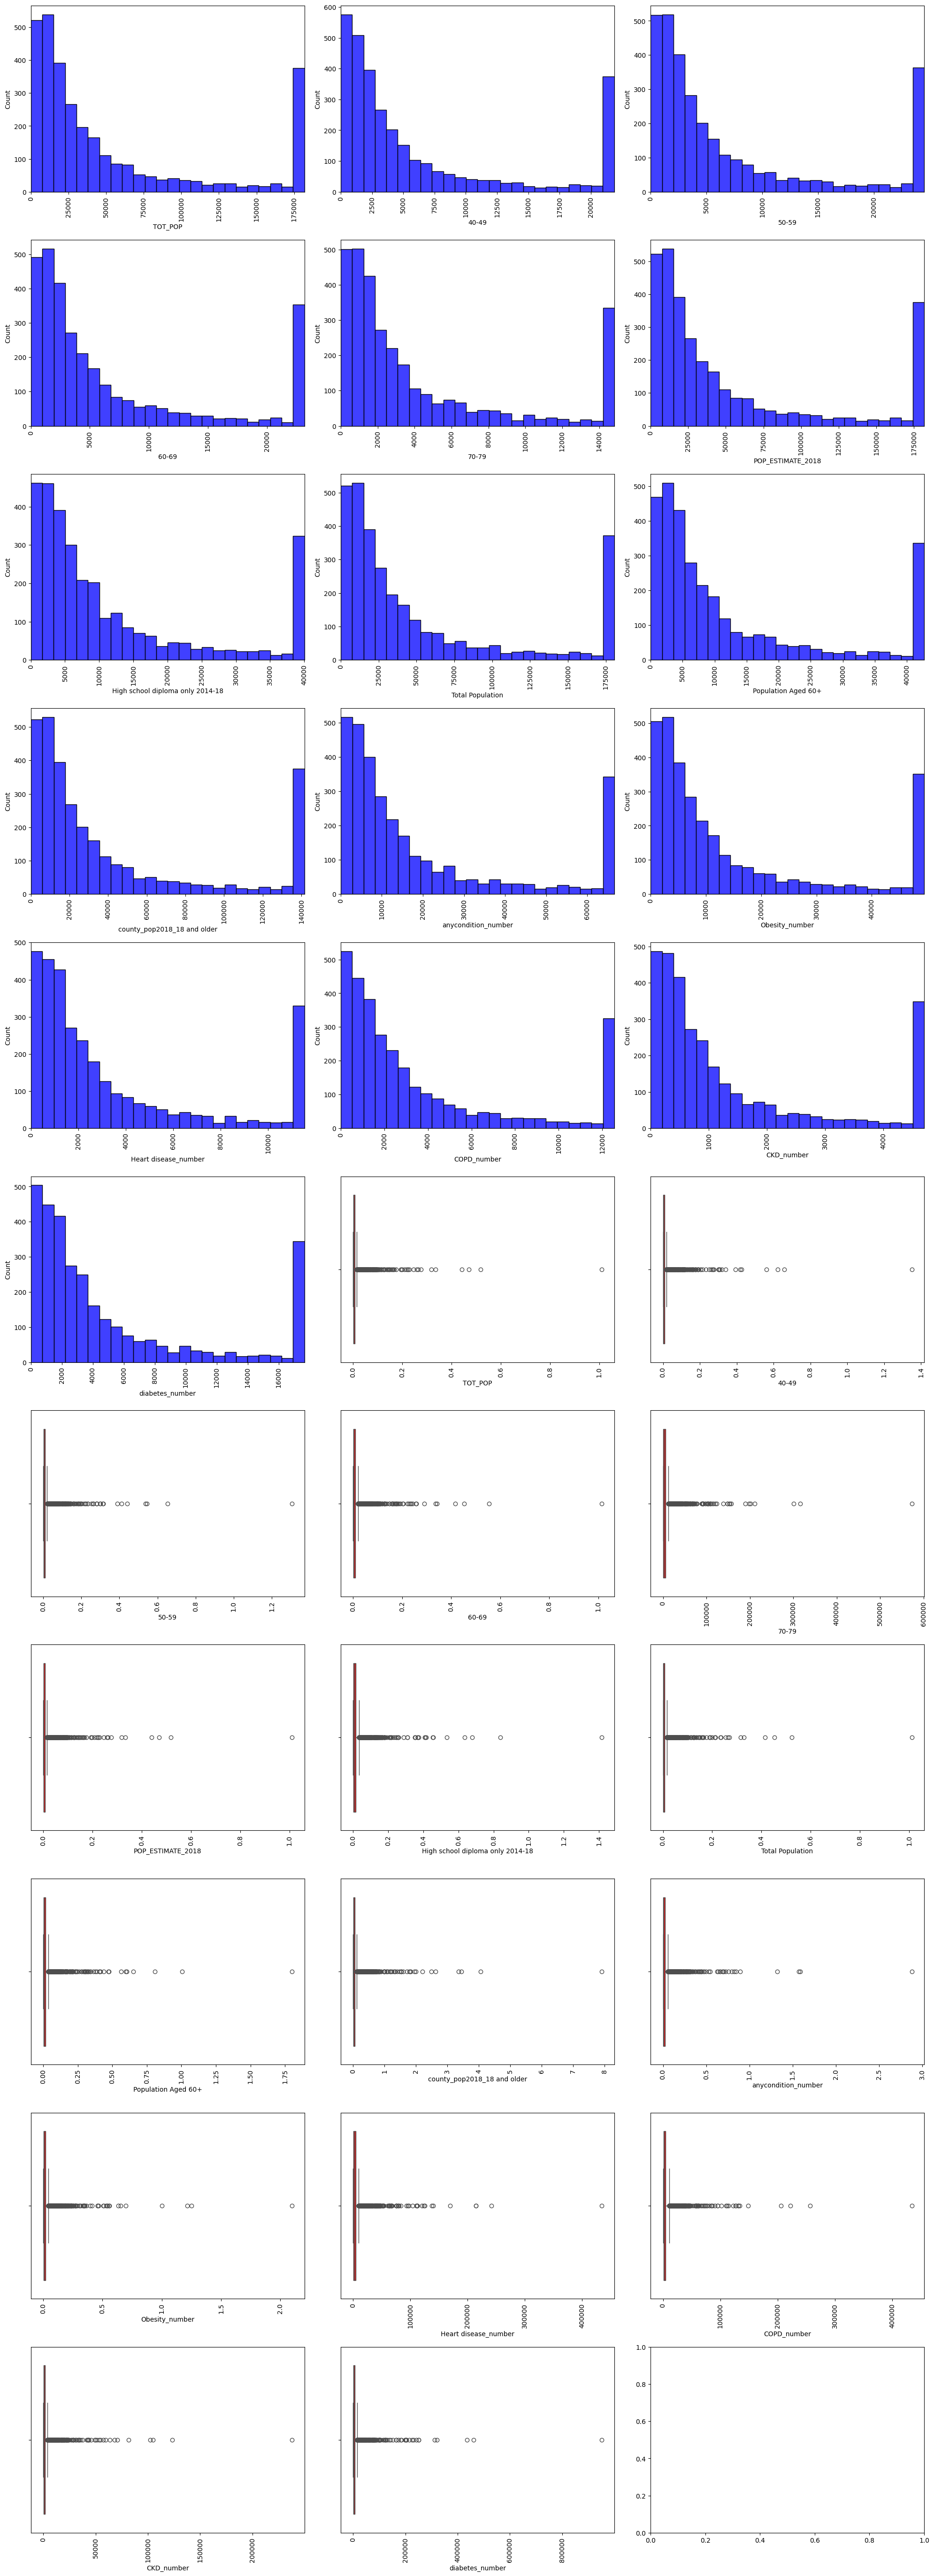

In [83]:
#4 ANálISIS UNIVARIABLE NUMERICO:
import matplotlib.pyplot as plt
import seaborn as sns
import math
df_graf_col = pd.DataFrame(df_rd_col, columns=['TOT_POP',"40-49","50-59","60-69","70-79","POP_ESTIMATE_2018",'High school diploma only 2014-18', 'Total Population',"Population Aged 60+","county_pop2018_18 and older","anycondition_number","Obesity_number","Heart disease_number",'COPD_number','CKD_number', 'diabetes_number'])
df_graf_sol = pd.DataFrame(df_rd_sol, columns=['TOT_POP',"40-49","50-59","60-69","70-79","POP_ESTIMATE_2018",'High school diploma only 2014-18', 'Total Population',"Population Aged 60+","county_pop2018_18 and older","anycondition_number","Obesity_number","Heart disease_number",'COPD_number','CKD_number', 'diabetes_number'])
def GrafUniNum(df_no_outliers, df_with_outliers, hist_vars, box_vars):
  """
  Creamos un conjunto de graficos, los histogramas sin outliers para presenciar mejor la distribucion,
  los graficos de caja con outliers para visualizarlos.
  Args:
      df_no_outliers
      df_with_outliers
      hist_vars: lista de nombres de columnas.
      box_vars: lista de nombres de columnas.
  """

  num_hist_vars = len(hist_vars)  #Determinamos el numero de variables para el histograma sin Ol's
  num_box_vars = len(box_vars)  #Determinamos el numero de variables para los graficos de caja con Ol's
  total_vars = num_hist_vars + num_box_vars

  #Determinamos la cuadricula de graficos optima, evitando el zero
  if total_vars <= 4:
    row, col = 2, 2  
  elif total_vars <= 6:
    row, col = 2, 3  
  else:
    # Usaremos una rejilla de graficos variablen en caso de exceder los casos anteriores.
    row = math.ceil(total_vars / 3)
    col = 3
  fig, axs = plt.subplots(row, col, figsize=(20, 5 * row))
  i = 0
  for var in hist_vars:
    row_index = i // col
    col_index = i % col
    sns.histplot(ax=axs[row_index, col_index], data=df_no_outliers, x=var, color="blue")
    max_val_no_outliers = df_no_outliers[var].max()
    axs[row_index, col_index].set_xlim(0, max_val_no_outliers)
    axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
    i += 1
  for var in box_vars:
    row_index = i // col
    col_index = i % col
    sns.boxplot(ax=axs[row_index, col_index], data=df_with_outliers, x=var, color="red")
    axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
    i += 1
  plt.tight_layout()
  plt.show()
#Preparamos la llamada a la funcion y el input
hist_vars = ['TOT_POP',"40-49","50-59","60-69","70-79","POP_ESTIMATE_2018",'High school diploma only 2014-18', 'Total Population',"Population Aged 60+","county_pop2018_18 and older","anycondition_number","Obesity_number","Heart disease_number",'COPD_number','CKD_number', 'diabetes_number']
box_vars = ['TOT_POP',"40-49","50-59","60-69","70-79","POP_ESTIMATE_2018",'High school diploma only 2014-18', 'Total Population',"Population Aged 60+","county_pop2018_18 and older","anycondition_number","Obesity_number","Heart disease_number",'COPD_number','CKD_number', 'diabetes_number']
GrafUniNum(df_graf_sol, df_graf_col, hist_vars, box_vars)